<h1><center> Machine Learning Engineer Nanodegree</center></h1>
<h2><center> Capstone</center></h2>
<h3><center> Jaime Aznar - June 12th, 2021</center></h3>

<h4><center><bold>Melanoma diagnosis using Machine Learning techniques on skin-mole images</bold></center></h4>



Over the past decades melanoma and skin cancer have spread. An early detection is considered to be a major factor when it comes to reducing the mortality rate associated with this type of cancer. The ability to detect the presence of malignant moles via images can prove to be a very useful tool in medical diagnosis.

##### Problem Statement

The goal of this project is to predict with a certain degree of accuracy if a certain mole is malignant or not. By applying machine learning techniques - such as CNN - we will be able to process an image of a skin mole and predict this value. By working in this solution, we will make it easier for doctors to determine if there are cancerous cells much faster and with higher accuracy.

##### Datasets and Inputs

The datasets we will be working with “The HAM10000 dataset” which contains 10.000 images of skin lesions classified into 10 clinical categories. These are color images with a medium-high resolution (450x600). The full dataset can be found at: https://datave
rse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T.

For this project, we will focus on distinguishing between two of the 10 classes (the two most common skin lessons, and the ones that are hardes to tell apart): the melanocytic nevi (benign) and the melanoma (cancerous). To make the problem more manageable, we will use a lower resolution version of the dataset, with 75x100 pixel images. The reduced dataset then contains 2000 75x100 pixel color images, of which 1000 are labeled as melanoma and 1000 are labeled as melanocytic nevi.

This dataset doesnt need proccessing beyond what is stated above.

##### Evaluation metrics

The evaluation metric for this project will consist of measuring how accurate the model is by using a confusion matrix where we can see the true and false positives/negatives.

##### Solution Statement

The solution will be a classification of the skin-mole in two categories (benign, malignant) and its percentage of accuracy. We will do so by building a convolutional neural network.
Benchmark Model
For this problem, the benchmark model will be reaching a +75% of accuracy based on the following published paper by BMC https://bmcmedimaging.biomedcentral.com/articles/10.1186/s12880-020-00534-8#Sec4.

In [1]:
import numpy as np
import random
import pickle

import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib as mpl
mpl.rc("figure", figsize=(16, 9))

In [2]:
def do_seeds(sn):
    np.random.seed(sn)
    torch.manual_seed(sn)
    random.seed(sn)

do_seeds(0)

#### Skin Cancer Dataset (HAM10000)

From a given image of a skin lesion (for example, a mole), we need to identify if it is benign or cancerous. We will do so by using The HAM10000 dataset, which contains 10.000 images of skin lesions classified into 10 different clinical categories of which we will focus on two: _melanocytic nevi_ (benign) and _melanoma_ (cancerous). These are colored images with a (450x600) resolution. 

Since this is just a project, to make this problem more manageable, we will use a lower resolution (75X100).


#### Preparing the data

In [3]:
# Split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

# Image processing utility to read and write images in various formats
from skimage import io

We start by loading the data from the _pickle_ file:

In [4]:
with open('ham_ss.dat', 'rb') as f:
    X_all, y_all = pickle.load(f)

In order to see what type of data we are working with we can print the shape of X_all, y_all.

As we will see below, these images are stored as _uint8_ numbers (which are integers between 0 and 255). Each number corresponds to one pixel and channel.

In [5]:
print(X_all.shape) #2000 images (R,G,B)
print(y_all.shape) # the image labels: 1-Cancerous, 0-benign

(2000, 3, 75, 100)
(2000,)


An image representation would look something like:

In [6]:
X_all[0,:,:,:]

array([[[103, 127, 134, ..., 117, 100,  73],
        [124, 150, 156, ..., 144, 128,  96],
        [131, 155, 159, ..., 153, 138, 106],
        ...,
        [107, 135, 150, ..., 113,  88,  56],
        [ 95, 123, 140, ...,  95,  68,  38],
        [ 73,  98, 113, ...,  67,  42,  20]],

       [[ 86, 105, 109, ..., 104,  87,  63],
        [105, 126, 130, ..., 129, 113,  84],
        [112, 132, 133, ..., 137, 123,  94],
        ...,
        [ 93, 118, 133, ...,  93,  70,  43],
        [ 82, 107, 124, ...,  77,  54,  28],
        [ 62,  85,  99, ...,  53,  33,  15]],

       [[ 88, 108, 113, ..., 112,  95,  69],
        [107, 130, 134, ..., 138, 122,  91],
        [112, 132, 136, ..., 147, 133, 102],
        ...,
        [ 90, 115, 132, ...,  96,  73,  48],
        [ 80, 105, 121, ...,  83,  60,  35],
        [ 63,  85,  98, ...,  60,  39,  21]]], dtype=uint8)

Since we already imported an image processing library we can transform this numbers into an actual image like so.

Note that in order for this to work, we need to place the color in the las dimension (as expected in skimage).

[1 1 1 1 1 0 0 0 0]


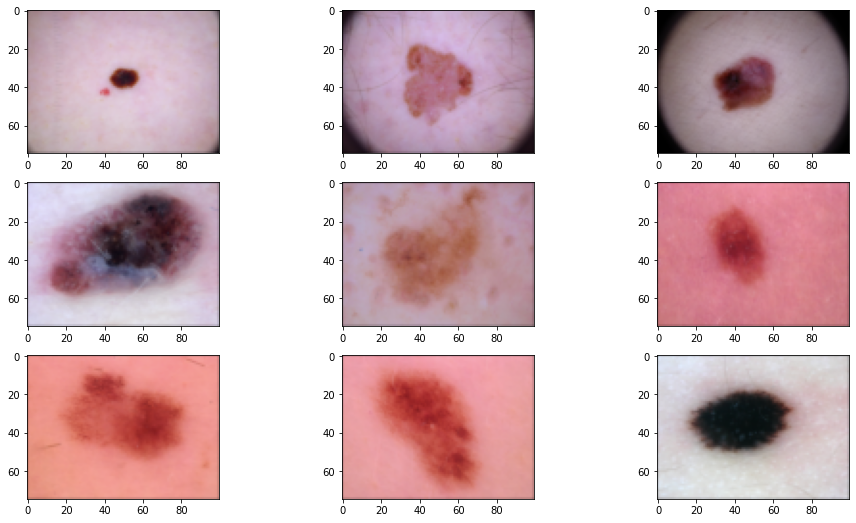

In [7]:
ax = io.imshow_collection(np.transpose(X_all[::230,:,:,:], (0,2,3,1)))
print(y_all[::230])

Since we know that the RGB values go between 0 and 255 we can "manually" rescale the variables between -0.5 and 0.5 in order to Normalize the data.

In [8]:
X_all_n = X_all / 255.0 - 0.5

Furthermore, we can stratify the data by separating it into train and test data so as to keep the same proportions of 0s and 1s in both.

We do this by applying _train_test_split_ method imported earlier.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_all_n, y_all, stratify=y_all, test_size=0.2,
                                                     random_state=142, shuffle=True)

### Classification with NN

Our approach will consist of using a Neural Network. As input we will directly provide the pixel values.

Our first step will be to load the dataset into a Pytorch tensor(s).

In [10]:
tX_train = torch.tensor(X_train, requires_grad=False, dtype=torch.float)
tX_test = torch.tensor(X_test, requires_grad=False, dtype=torch.float)
ty_train = torch.tensor(y_train, requires_grad=False, dtype=torch.long)  
ty_test = torch.tensor(y_test, requires_grad=False, dtype=torch.long)  

In [11]:
tX_train_l = tX_train.view(tX_train.shape[0], 22500) # For our network's input shape
tX_test_l = tX_test.view(tX_test.shape[0], 22500) # For our network's input shape

### Building the NN

To classify the images, we will implement a neural net that given an image output (the intensity value for each color at each pixel)  the probability that the image represents a benign or a cancerous lesion. 

The input layer will then have as many elements as values we have in the image (3x75x100 = 22500), and our output layer will have two elements. For simplicity, we will choose only one hidden layer, with 100 elements.

#### Forward-pass architecture

As shown in the proposal, the network architecture will be as bellow:

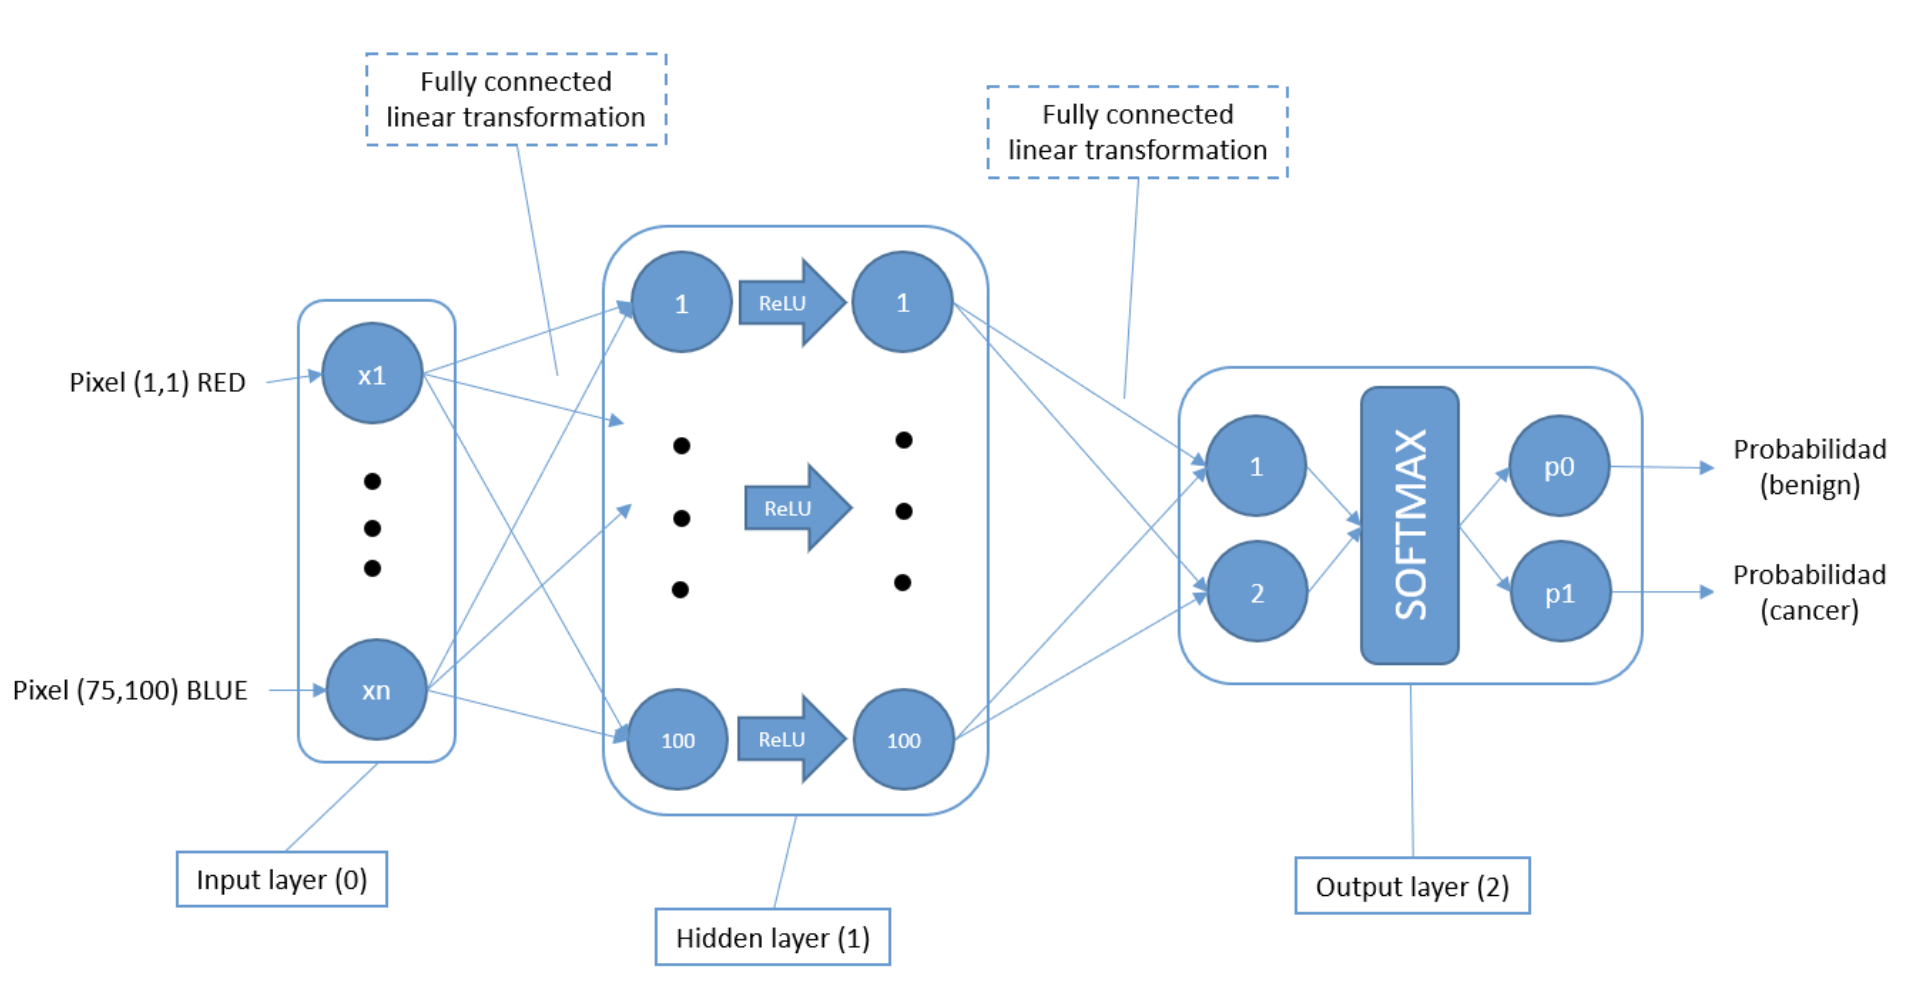

As our first layer (a.k.a hidden layer) we will use a ReLU activation function:

- $\mathrm{ReLU}(x) = \mathrm{max}(0, x)$

For the output layer we will implement the _Softmax_ function as we want to get probabilities as an output. The _Softmax_ function does so by rescaling the outputs between 0 and 1.

- $\mathrm{Softmax}(x)_i = \frac{e^{x_i}}{\sum_j e^{x_j}}$


####   'Forward-Pass' as Pytorch modules

If we were to implement our NN using matrix products this would grow complicated quickly. To avoid this, Pytorch provides us with the _module_ structure.

A _module_ is an object that implements the _forward()_ function.

Although we could _easily_ create our own modules, Pytorch has the _Linear module_ which fits our needs.

We define the forward pass:

In [12]:
nn1 = torch.nn.Sequential(
    torch.nn.Linear(3*75*100, 100), # Linear layer, 22500 inputs and 100 outputs
    torch.nn.ReLU(),  # ReLU activation
    torch.nn.Linear(100, 2), # Linear layer, 100 inputs and 2 outputs
    torch.nn.LogSoftmax(dim=1) # the output is the log-probability of belonging to each category (benign or cancerous)
)

We set up the parameter initialization:

In [13]:
def init_f(forw):
    for nam, param in forw.named_parameters():
        if 'weight' in nam:
            torch.nn.init.xavier_normal_(param) 
        else:
            param.data.fill_(0.01)

Now, if we were to approach this directly we would see that our forward pass would work and therefore it would give us probabilities. 

However, these probabilities would be meaningless at this point since the network has not been trained yet, so the probabilities  outputted wouldnt correlate with the labels. 

To train the network we need a way to measure how good our predictions (probabilities) are: we need to define the _loss function_. The loss function is a function that, given a set of predicted probabilities for some images and their true labels, outputs a value that is lower the better the predictions are. 

For classification problems, the standard loss function is the NLLLoss (negative log likelihood loss). For a given image, with its prediction and its label, the NLLLoss is given by:

 - $l_{nll}(p,l) = -l\log p -(1-l)\log(1-p)$

For a set of images, the total loss is the average of each individual loss.

We can define our loss function as:

In [14]:
def loss_f(x, y, forw):
    return torch.nn.functional.nll_loss(forw(x), y)

### Optimizers (Training the network)

We have our forward pass and our loss function ready, so we can begin the training process. For training our network, we just need to find the weights for our network that give the best predictions. That is: we need to find a set of values for our weights that minimize the loss.

For that, we just need to proceed as we would for minimizing any function: we can proceed iteratively, performing one step at a time in the direction of the gradient. In general, there are multiple ways one can perform these steps, but a simple and reliable method is SGD (stochastic gradient descent), that just performs a step of fixed size (given by the learning rate) in the gradient's direction. 

Pytorch provides a variety of optimization methods through the _optimizer_ objects. An optimizer is an object that implements a function _step()_ that modifies the network's parameters at each iteration.

First we define the training step function:

In [15]:
def t_step(x, y, forw, opt):
    opt.zero_grad() # we reset the accumulated gradient values
    loss = loss_f(x, y, forw) # we calculate current loss
    out = loss.item() # we keep the loss value for plotting it later...
    loss.backward() # we backpropagate the gradients with respect to our parameters
    opt.step() # we let the optimizer take a step
    return out

Secondly, our optimizer:

In [16]:
opt1 = torch.optim.SGD(nn1.parameters(), lr=0.0025)

Finally, the training:

In [17]:
do_seeds(29)
init_f(nn1)

In [18]:
for i in range(1000):
    out = t_step(tX_train_l, ty_train, nn1, opt1)
    if i%200 == 0:
        print("Epoch: {}, Loss: {:.4f}".format(i, out))

Epoch: 0, Loss: 0.6609
Epoch: 200, Loss: 0.4744
Epoch: 400, Loss: 0.4420
Epoch: 600, Loss: 0.4200
Epoch: 800, Loss: 0.4022


### Evaluation and Predictions

Now that the network is trained, we can start predicting and checking the probability score on both the training and testing sets.

To help us with this, we will define some helper functions:

In [19]:
def pred_f(x, forw):
    with torch.no_grad():
        _, y_pred = torch.max(forw(x), dim=1)
    return y_pred

In [20]:
def score_f(x, y, forw):
    with torch.no_grad():
        y_pred = pred_f(x, forw)
        score = torch.sum(y_pred == y).item() / len(y)
    return score

In [21]:
print(score_f(tX_train_l, ty_train, nn1))
print(score_f(tX_test_l, ty_test, nn1))

0.828125
0.775


### Visualizing

To see more clearly what is happening to our network, we can repeat the training process, but this time recording the train and test losses and scores during the process.

The training and testins scores look to be closer, but the results arent great. We can see this more in detail by plotting it.

In [22]:
do_seeds(29)
init_f(nn1)

In [23]:
tr_stats = np.stack([np.array([i, t_step(tX_train_l, ty_train, nn1, opt1), loss_f(tX_test_l, ty_test, nn1).item(),
    score_f(tX_train_l, ty_train, nn1), score_f(tX_test_l, ty_test, nn1)]) for i in range(1000)], axis=0)

In [24]:
tr_stats_df = pd.DataFrame(tr_stats, columns=['epoch', 'tr_loss', 'te_loss', 'tr_score', 'te_score'])

[None]

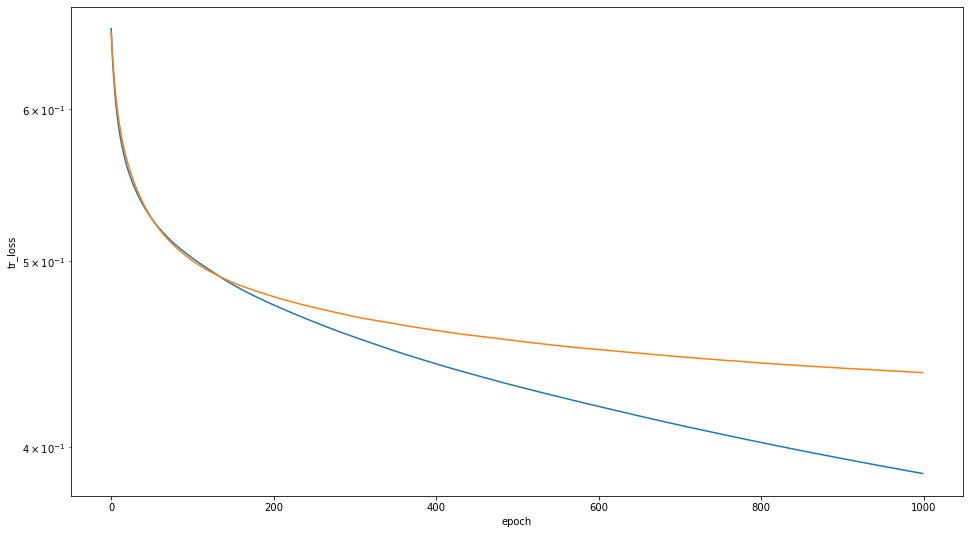

In [25]:
ax = sns.lineplot(x='epoch', y='tr_loss', data=tr_stats_df, legend='full')
sns.lineplot(x='epoch', y='te_loss', data=tr_stats_df, legend='full', ax=ax)
ax.set(yscale="log")

<AxesSubplot:xlabel='epoch', ylabel='tr_score'>

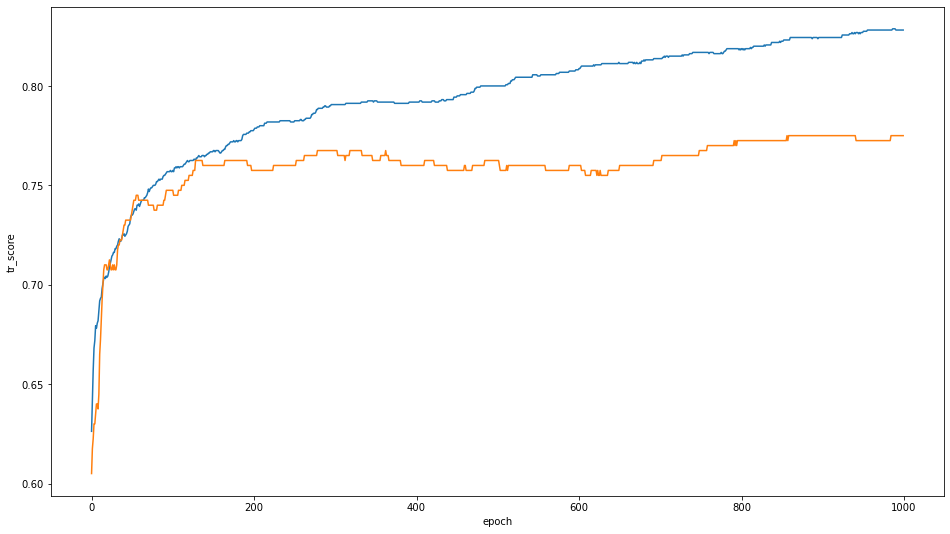

In [26]:
sns.lineplot(x='epoch', y='tr_score', data=tr_stats_df)
sns.lineplot(x='epoch', y='te_score', data=tr_stats_df)

## Classification with Convolutional NN 

As we have seen, our fully connected network is not performing as good as we hoped, and has overfitting issues. Even in the simplest and smallest form (with only one hidden layer), our network has a huge number of parameters (>2M). 

To reduce the number of parameters and use the image information more efficiently we can leverage the spatial information provided by the pixels' locations in the image. We can do that by using _convolutional_ and _max pooling_ layers layers instead of fully connected layers.

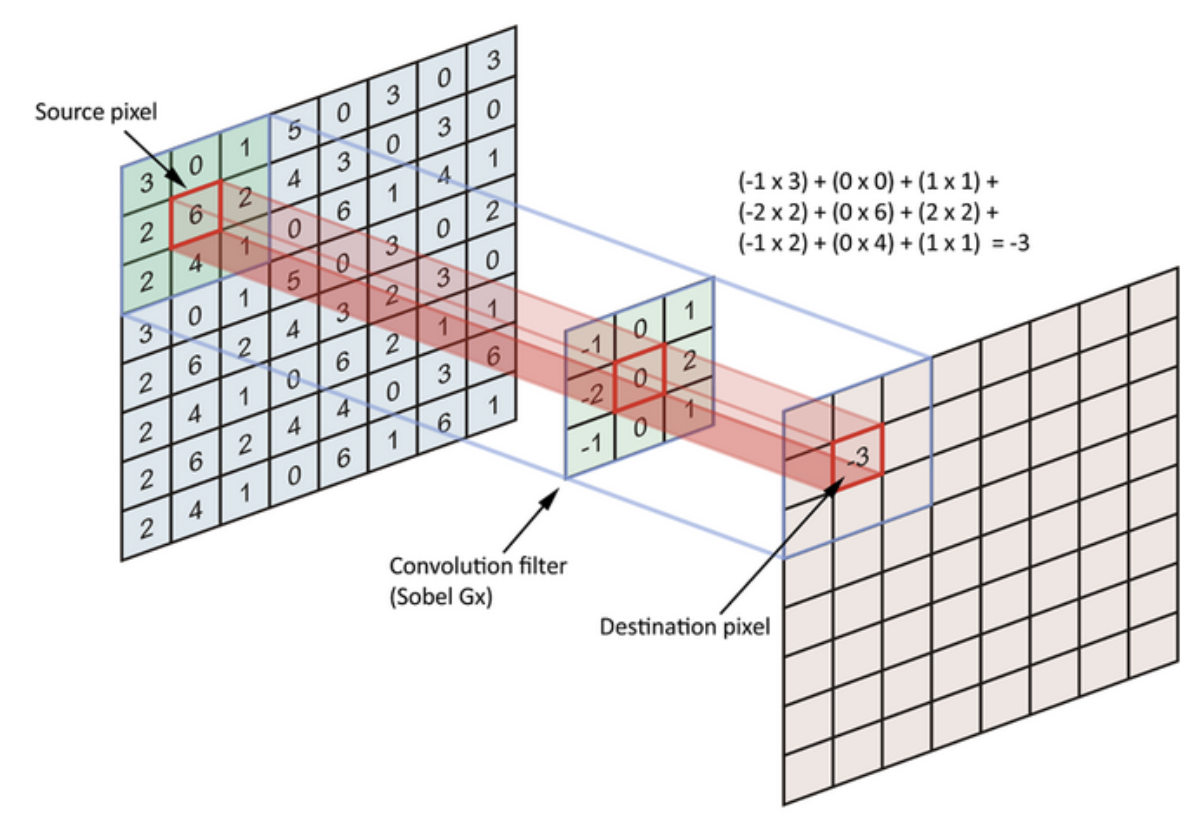

For generating the output image, the filter goes through the input image, pixel by pixel, calculating the value. Besides the filter (_kernel_) size $n$, there is two additional parameters that we can change: the _stride_ and the _padding_. The _stride_ $s$ is the number of pixels that the filter moves at each step. The _padding_ $p$ is the number of additional pixels that we add in the borders of the input image before applying the filter (typically filled with value $0$) so taht the filter can go through more pixels.

### Building the Convolutional NN

CNNs typically start with a series of convolutional layers alternated with max pooling layers that reduce the image dimensionality and extract features with a small number of parameters, and finish with a series of fully connected layers that perform the classification. 

For our skin lesion classification problem we will use the following architecture:

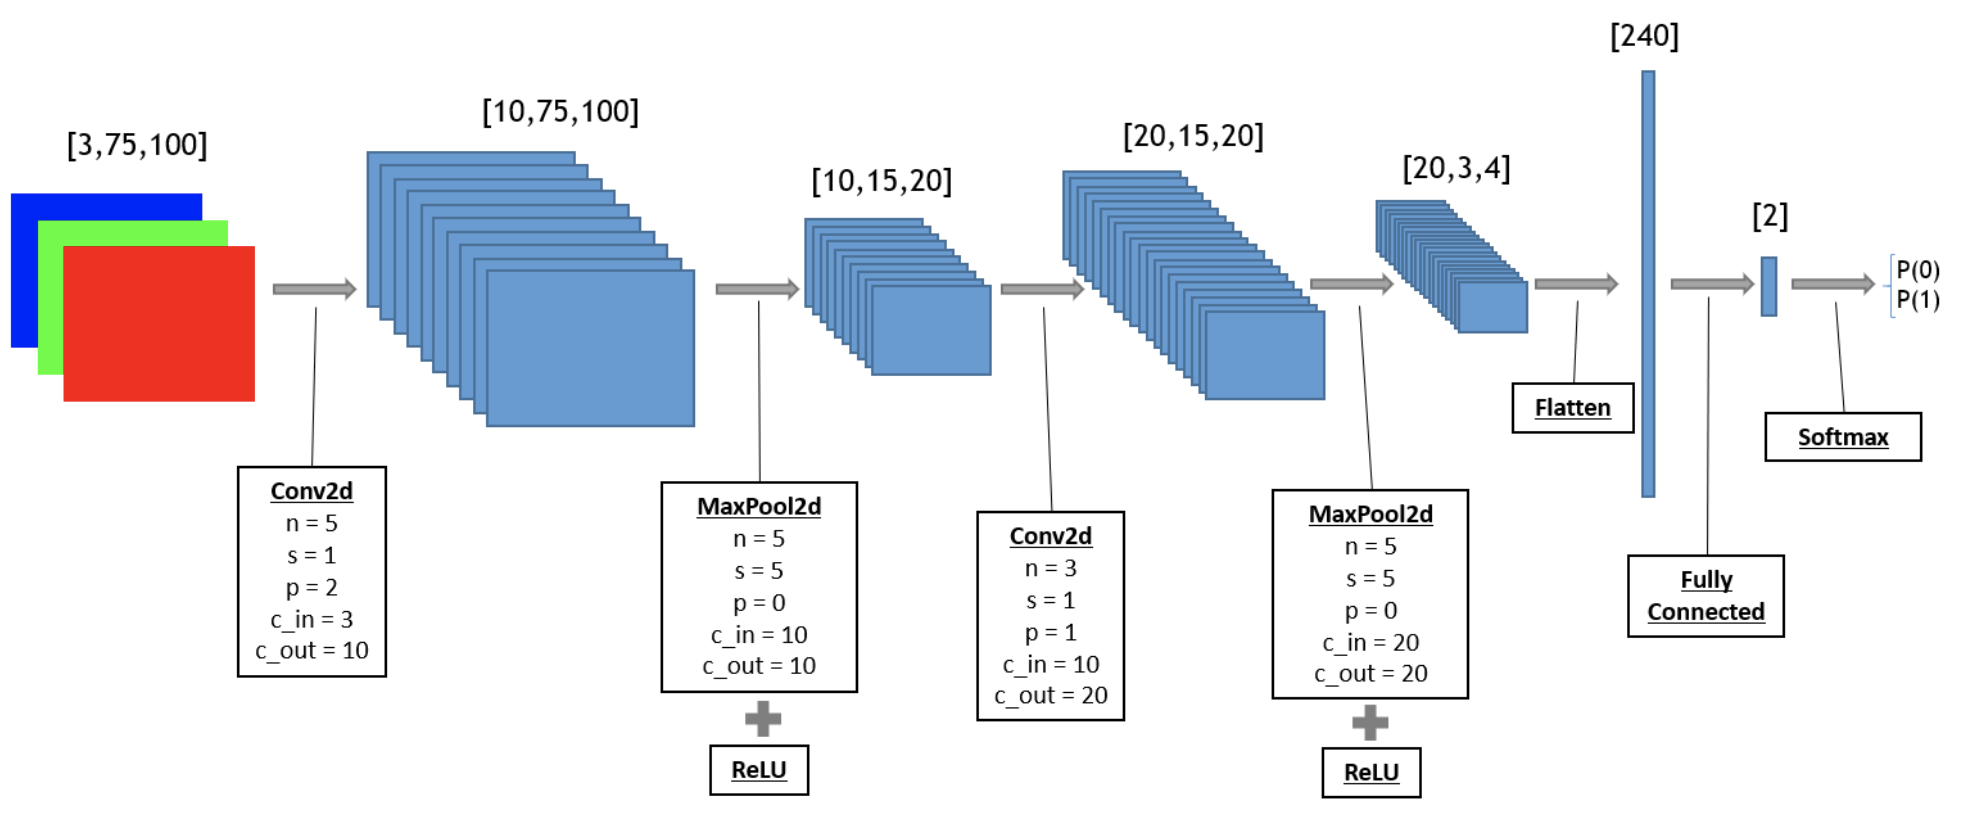

In [28]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [29]:
cnn1 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2),
    torch.nn.MaxPool2d(5),
    torch.nn.LeakyReLU(),

    torch.nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1),
    torch.nn.MaxPool2d(5),
    torch.nn.LeakyReLU(),

    Flatten(),
    torch.nn.Linear(240, 2), 
    torch.nn.LogSoftmax(dim=1) 
)

### A small improvement: mini-batches

We have seen how the train score (and loss) keeps getting better, but the test score starts getting worse after some time. This happens because we are overfitting the data, and our network is minimizing the error on the training loss but it does not generalize to the test loss.
There is two strategies that can help: regularization (to reduce the network's complexity) and mini-batches (to avoid local optima, and also train faster!).

Training with minibatches consists on using a subset of the data at each training step, instead of the whole dataset. At each iteration step, we sample a small portion of the data and use it to compute the gradient and change the weights (each 'complete' pass through the data set, after a number of iterations depending on the mini-batch size, is called an epoch).

The _DataLoader_ class generates an iterable object that provides mini-batches for the training. We can use it to train the network in this way:

In [30]:
do_seeds(1)
init_f(cnn1)

In [31]:
opt1 = torch.optim.Adam(cnn1.parameters(), weight_decay=0.008, lr=0.0002)

In [32]:
mini_b = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(tX_train, ty_train), 
                                       batch_size=100, shuffle=True) 

In [33]:
for i in range(500): 
    for x_j, y_j in mini_b:
        out = t_step(x_j, y_j, cnn1, opt1) 
    if i%10 == 0:
        print("Epoch: {}, Loss: {:.4f}".format(i, out))

Epoch: 0, Loss: 0.6628
Epoch: 10, Loss: 0.4600
Epoch: 20, Loss: 0.3864
Epoch: 30, Loss: 0.4505
Epoch: 40, Loss: 0.4928
Epoch: 50, Loss: 0.3845
Epoch: 60, Loss: 0.4900
Epoch: 70, Loss: 0.4469
Epoch: 80, Loss: 0.3523
Epoch: 90, Loss: 0.3896
Epoch: 100, Loss: 0.4373
Epoch: 110, Loss: 0.3876
Epoch: 120, Loss: 0.3997
Epoch: 130, Loss: 0.3499
Epoch: 140, Loss: 0.3720
Epoch: 150, Loss: 0.3829
Epoch: 160, Loss: 0.4066
Epoch: 170, Loss: 0.4295
Epoch: 180, Loss: 0.3699
Epoch: 190, Loss: 0.4031
Epoch: 200, Loss: 0.2943
Epoch: 210, Loss: 0.3113
Epoch: 220, Loss: 0.2689
Epoch: 230, Loss: 0.3359
Epoch: 240, Loss: 0.2737
Epoch: 250, Loss: 0.3059
Epoch: 260, Loss: 0.3133
Epoch: 270, Loss: 0.3513
Epoch: 280, Loss: 0.3471
Epoch: 290, Loss: 0.3297
Epoch: 300, Loss: 0.3418
Epoch: 310, Loss: 0.3044
Epoch: 320, Loss: 0.3124
Epoch: 330, Loss: 0.2941
Epoch: 340, Loss: 0.3273
Epoch: 350, Loss: 0.3264
Epoch: 360, Loss: 0.3431
Epoch: 370, Loss: 0.3392
Epoch: 380, Loss: 0.3346
Epoch: 390, Loss: 0.3517
Epoch: 400,

In [34]:
print(score_f(tX_train, ty_train, cnn1))
print(score_f(tX_test, ty_test, cnn1))

0.850625
0.83


As we can see we have gotten a better value por our testing data. And as done before, to see more clearly what is happening to our network, we can repeat the training process, but this time recording the train and test losses and scores during the process.

The training and testins scores look to be closer, but the results arent great. We can see this more in detail by plotting it.

In [35]:
do_seeds(29)
init_f(cnn1)

In [39]:
tr_stats2 = np.stack([np.array([i, np.mean(list(t_step(x_j, y_j, cnn1, opt1) for x_j, y_j in mini_b)),
    loss_f(tX_train, ty_train, cnn1).item(), loss_f(tX_test, ty_test, cnn1).item(),
    score_f(tX_train, ty_train, cnn1), score_f(tX_test, ty_test, cnn1)]) for i in range(500)], axis=0)

In [40]:
tr_stats2_df = pd.DataFrame(tr_stats2, columns=['epoch', 'mean_loss', 'tr_loss', 'te_loss', 'tr_score', 'te_score'])

[None]

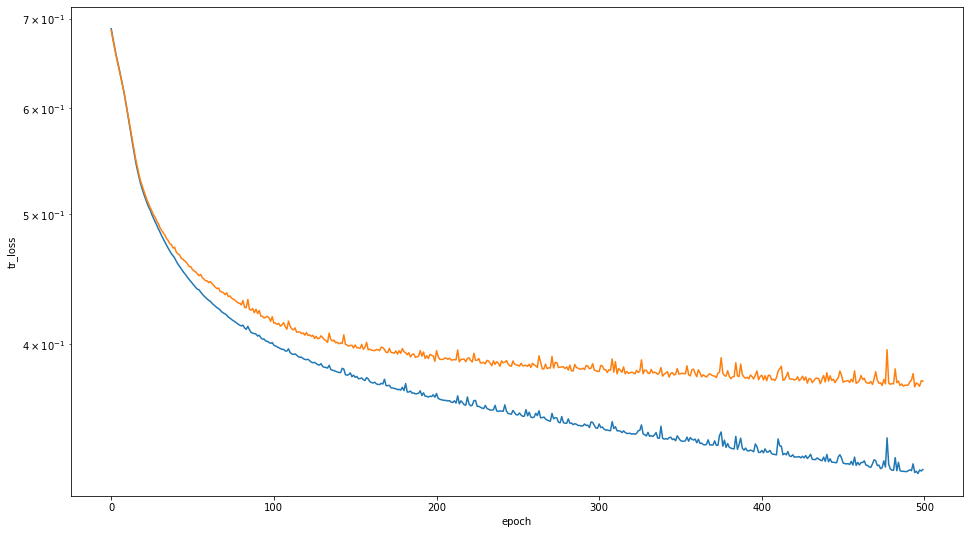

In [41]:
ax = sns.lineplot(x='epoch', y='tr_loss', data=tr_stats2_df)
sns.lineplot(x='epoch', y='te_loss', data=tr_stats2_df, ax=ax)
ax.set(yscale="log")

<AxesSubplot:xlabel='epoch', ylabel='tr_score'>

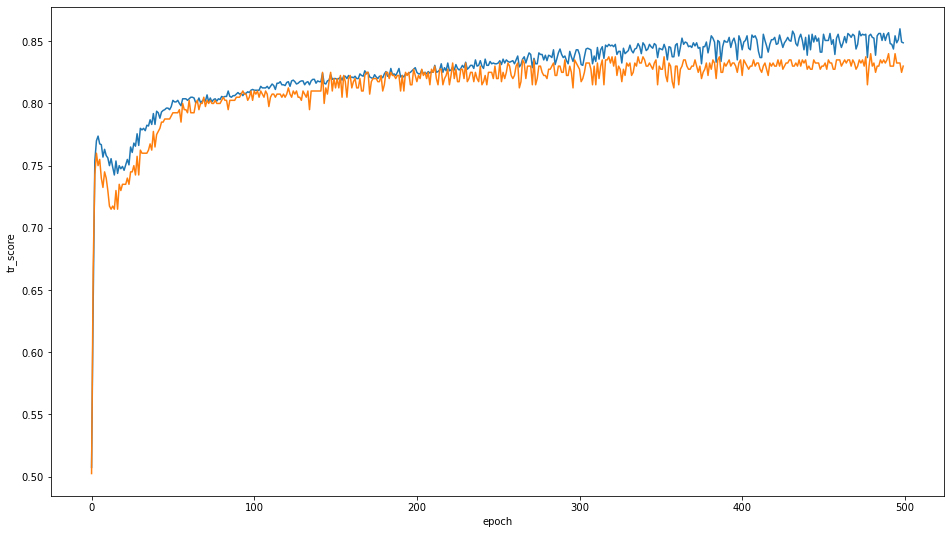

In [42]:
sns.lineplot(x='epoch', y='tr_score', data=tr_stats2_df)
sns.lineplot(x='epoch', y='te_score', data=tr_stats2_df)

We can definitely see an improvement compared with our first approach!

### Robustness to image translation

In [43]:
X_test.shape

(400, 3, 75, 100)

In [44]:
tr_W = np.array(list(range(-50,50)))
X_test_Ws = [np.roll(X_test, i, axis=3) for i in tr_W]

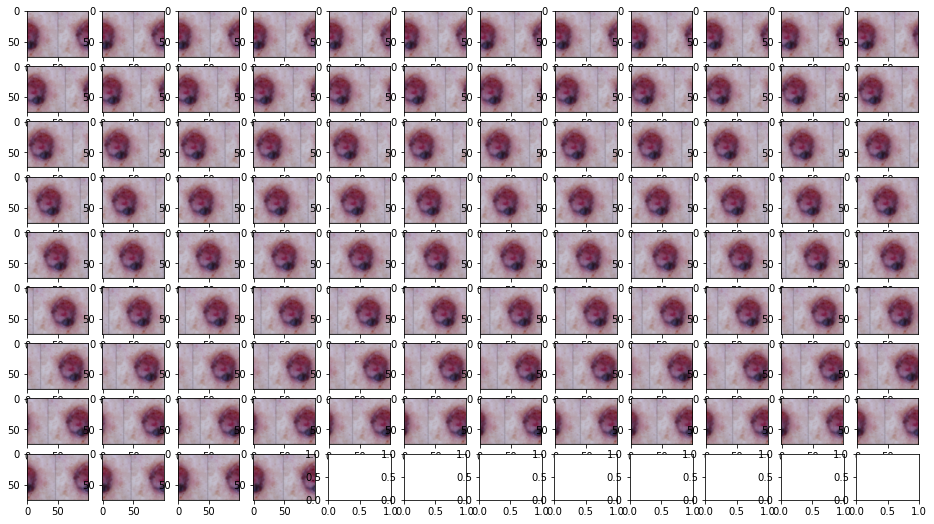

In [45]:
im = io.imshow_collection([np.transpose(0.5+xi[0,:,:,:],(1,2,0)) for xi in X_test_Ws])

In [52]:
nn1_scores = [score_f(torch.tensor(xi.reshape(xi.shape[0],-1), requires_grad=False, dtype=torch.float).cpu(), 
                      ty_test, nn1) for xi in X_test_Ws]

In [53]:
cnn1_scores = [score_f(torch.tensor(xi, requires_grad=False, dtype=torch.float).cpu(), 
                      ty_test, cnn1) for xi in X_test_Ws]

In [54]:
all_scores = pd.DataFrame(data={'nn1': nn1_scores,
                                'cnn1': cnn1_scores}, index=tr_W)

<AxesSubplot:>

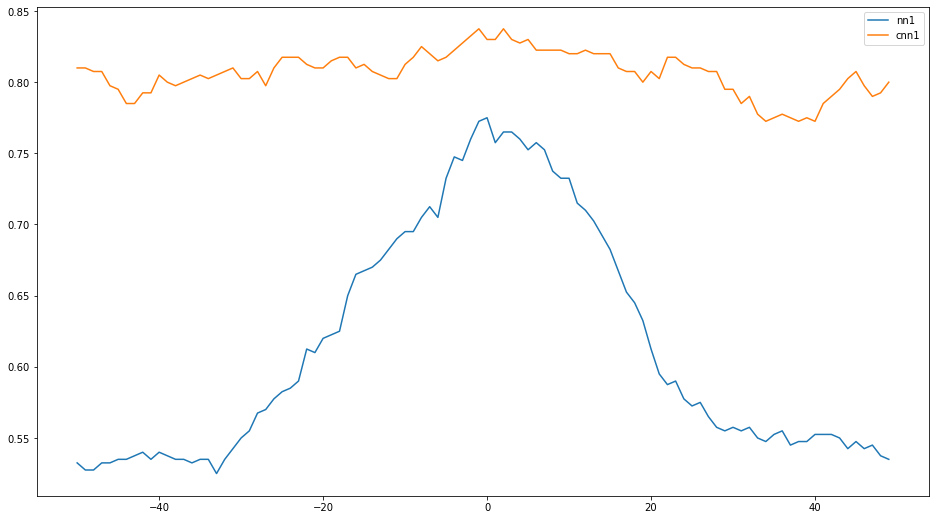

In [55]:
all_scores.plot()

### Visualizing the filters

We can visualize the effect of the filters that our CNN has learned. For that we simply evaluate the trained network until the layer we want to visualize.

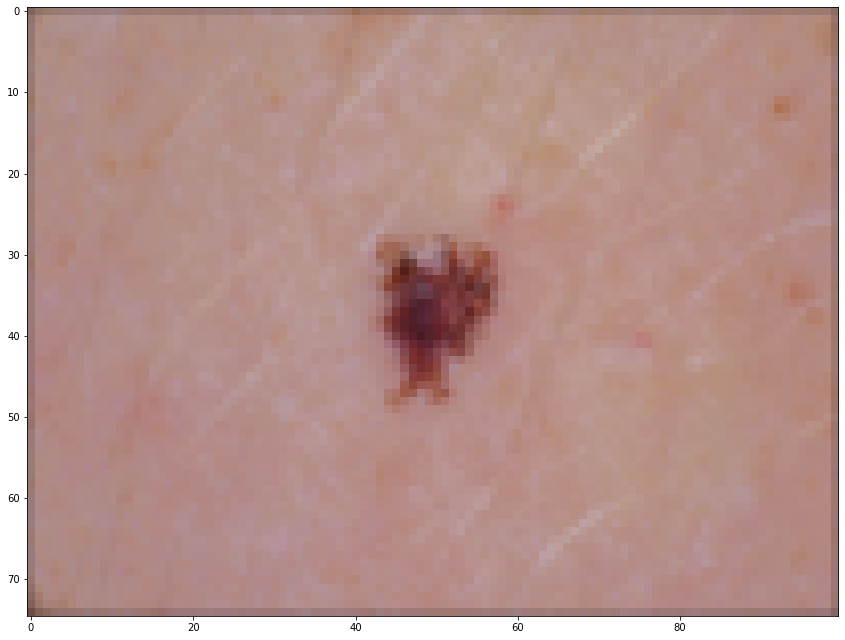

In [56]:
io.imshow(np.transpose(0.5+tX_train[0,:,:,:].cpu().detach().numpy(),(1,2,0)))

[<Figure size 1152x648 with 4 Axes>,
 <Figure size 1152x648 with 12 Axes>,
 <Figure size 1152x648 with 12 Axes>,
 <Figure size 1152x648 with 12 Axes>,
 <Figure size 1152x648 with 20 Axes>,
 <Figure size 1152x648 with 20 Axes>,
 <Figure size 1152x648 with 20 Axes>]

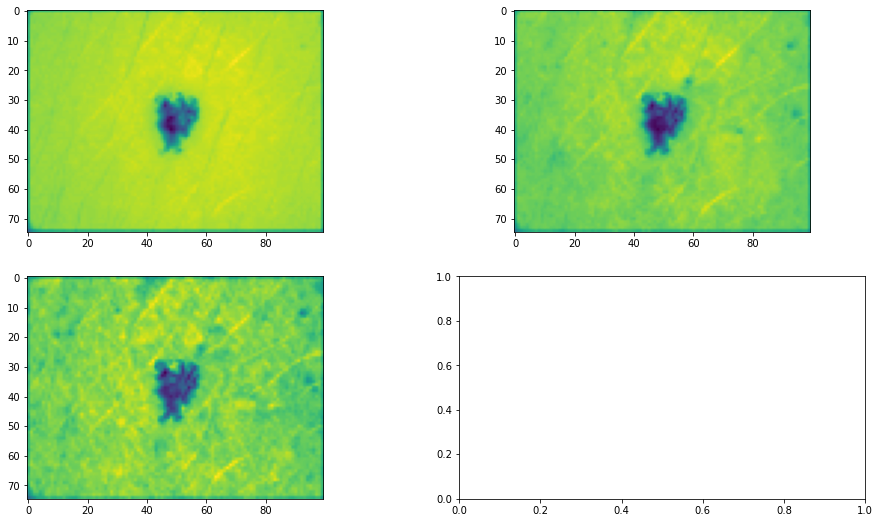

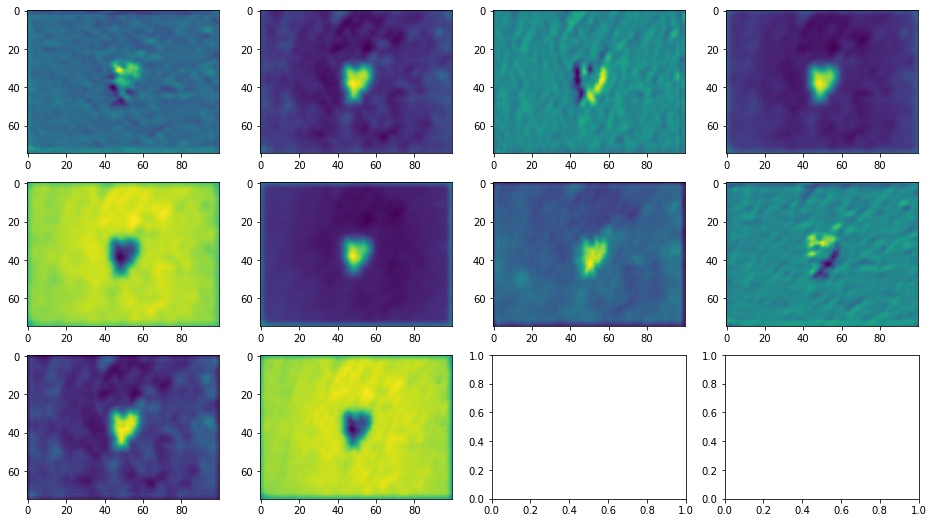

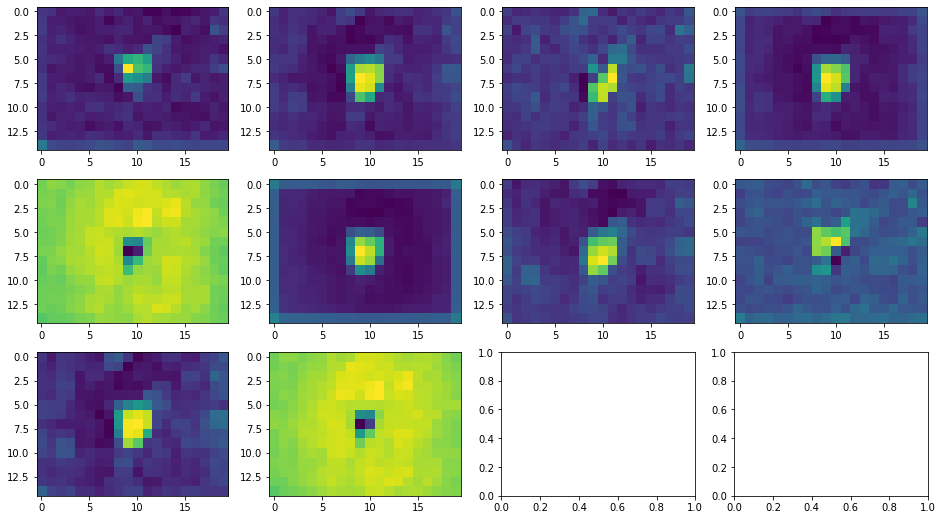

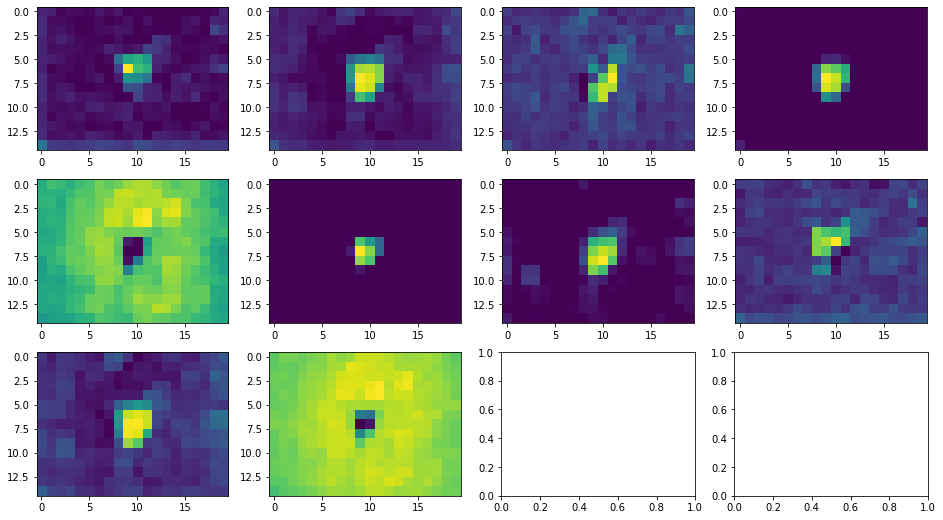

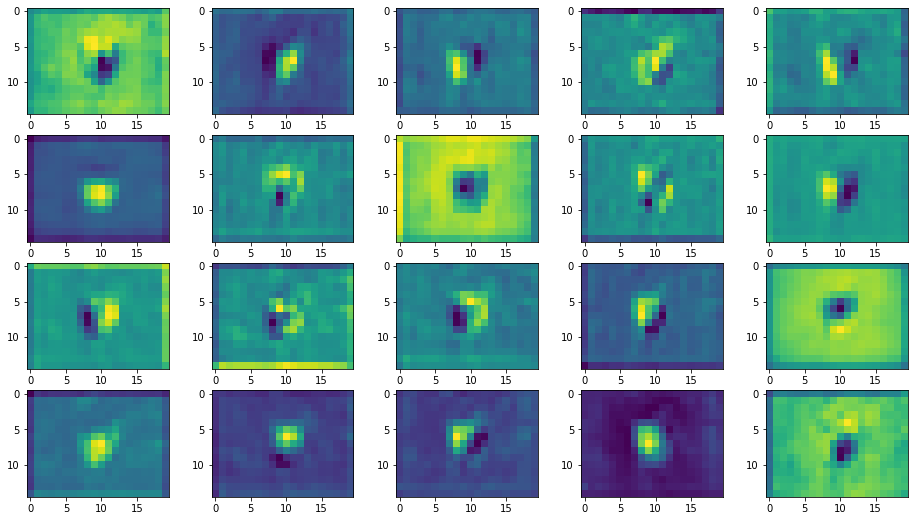

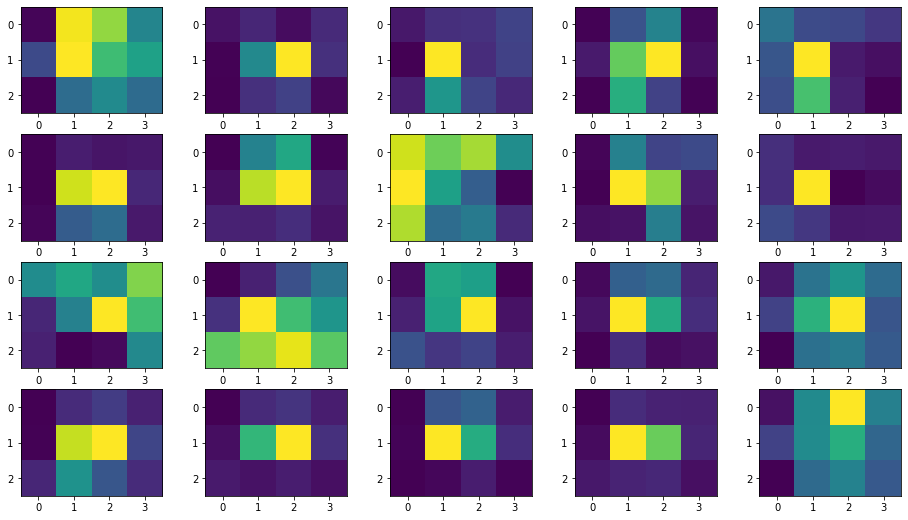

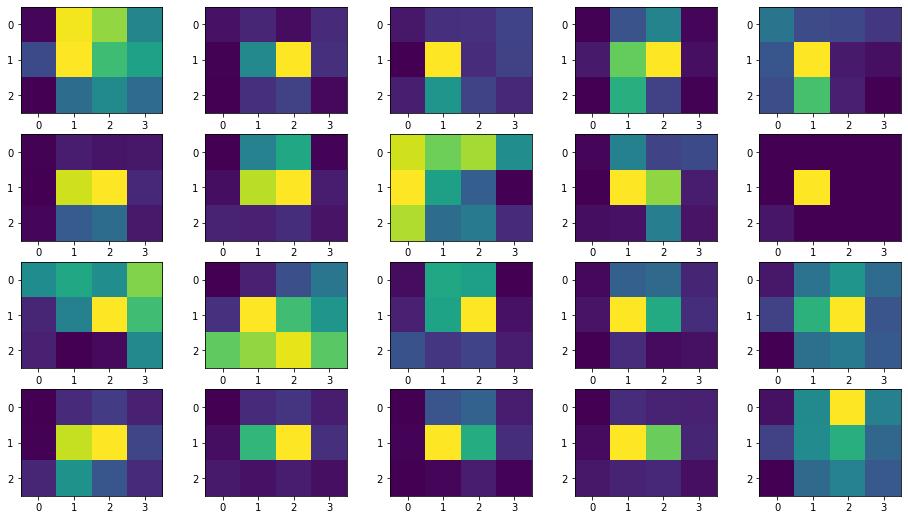

In [58]:
[io.imshow_collection(cnn1[:ii](tX_train[0:1,:,:,:]).cpu().detach().numpy().squeeze()) for ii in range(7)]

### Putting the model into production

Now that we have a reasonable CNN we can deploy our model into a service (for example a REST API) so that we can consume it from different applications.
For that, we first need to prepare a preprocessing pipeline to ensure that we transform the images into the input shape that our model accepts.
Although there are more general and powerful approaches, for simplicity we will just take the input image, transpose it into landscape mode if necessary, select the central 1/3 of the image and resize it so that it has the correct input resolution (75x100 pixels).

In [59]:
from skimage.transform import resize

In [60]:
def preprocess(input_img):
    imgg = np.transpose(input_img, (np.argmin(input_img.shape[:2]), np.argmax(input_img.shape[:2]), 2))
    #x_r = list((np.arange(-imgg.shape[1]/6.0, imgg.shape[1]/6.0) + imgg.shape[1]/2.0).astype(int))
    #y_r = list((np.arange(-imgg.shape[1]/8.0, imgg.shape[1]/8.0) + imgg.shape[0]/2.0).astype(int))
    x_min = int(-imgg.shape[1]/6.0 + imgg.shape[1]/2.0)
    x_max = int(+imgg.shape[1]/6.0 + imgg.shape[1]/2.0)
    y_min = int(-imgg.shape[1]/8.0 + imgg.shape[0]/2.0)
    y_max = int(+imgg.shape[1]/8.0 + imgg.shape[0]/2.0)
    return resize(imgg[y_min:y_max, x_min:x_max, :], (75,100), anti_aliasing=True)#, preserve_range=True).astype(np.uint8)
    

In [89]:
def predict_img(input_img):
    pre_img = preprocess(input_img)
    t_img = torch.tensor((np.transpose(preprocess(pre_img)[np.newaxis,:,:,:], (0,3,1,2)) - 0.5), 
                         requires_grad=False, dtype=torch.float).cpu()
    pred_n = pred_f(t_img, cnn1).item()
    pred_p = np.exp(cnn1(t_img).cpu().detach().numpy())[0][pred_n]
    return pred_n, pred_p

In [90]:
# We can now save our model into a Pytorch file:
# torch.save(nn2.state_dict(), 'nn2.pt')

Bellow are some test done with pictures of moles passed as parameters to the `predict_img` function

In [91]:
import numpy as np
from PIL import Image
img = Image.open('test-mole.jpeg')
arr = np.array(img) 
predict_img(arr)

(0, 0.98403925)

In [92]:
img2 = Image.open('test-mole2.jpeg')
arr2 = np.array(img2)
predict_img(arr2)

(0, 0.91052294)

### Conclusions

This project serves as a good starting point to enter into the domain of Machine Learning. Although for this particular project there was no need for Data processing, both exploration and visualizations are extremely important before training any Machine Learning model as it helps in choosing a suitable performance metric for evaluating the model. 

As shown above our CNN model in Pytorch works with tensor including RGB values. All images need to be reshaped into the same shape for training the CNN models in batch.

Training CNN models from scratch is computationally expensive and time-consuming which is the reason why we have chosen Convolutional Networks (with less than 3 layers), minibaches and low range parameters in order to reduce the time needed to compute. For this particular case, the Notebook took almost 3 hours to run.

The most interesting thing to note besides the power of convolutional networks and the ability of a model to make such predicitions is the power of minibatches and how this approach can dramatically reduce the computing time.

Considering our (my) current level of ML understanding and that our benchmark was to match the 75% accuracy reached in the aforementioned study, we can say that we have achived our goal. Nevertheless, it is clear that with more computing power, and increase in the number of epoch and Neural layers (both to some extent - to many can worsen the model - )and a greater dataset can improve the model way beyond the 95% threshold.

#### Disclaimer

Images related to the CNN where taken form the internet and its used was merely for explanatory purposes.